In [2]:
!pip install squarify

In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 26.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

# Import packages for warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (750000, 10)
Test: (250000, 9)


In [7]:
train_df.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [8]:
# Change column names to lower_case & replace space with underscore
train_df.columns = train_df.columns.str.replace(' ', '_').str.lower()
test_df.columns = test_df.columns.str.replace(' ', '_').str.lower()

In [9]:
print("Missing Values in Train:", train_df.isna().sum().sum())
print("Missing Values in Test:", test_df.isna().sum().sum())

print("Duplicates in Train:", train_df.drop(columns=['id']).duplicated().sum())
print("Duplicates in Test:", test_df.drop(columns=['id']).duplicated().sum())

Missing Values in Train: 0
Missing Values in Test: 0
Duplicates in Train: 0
Duplicates in Test: 0


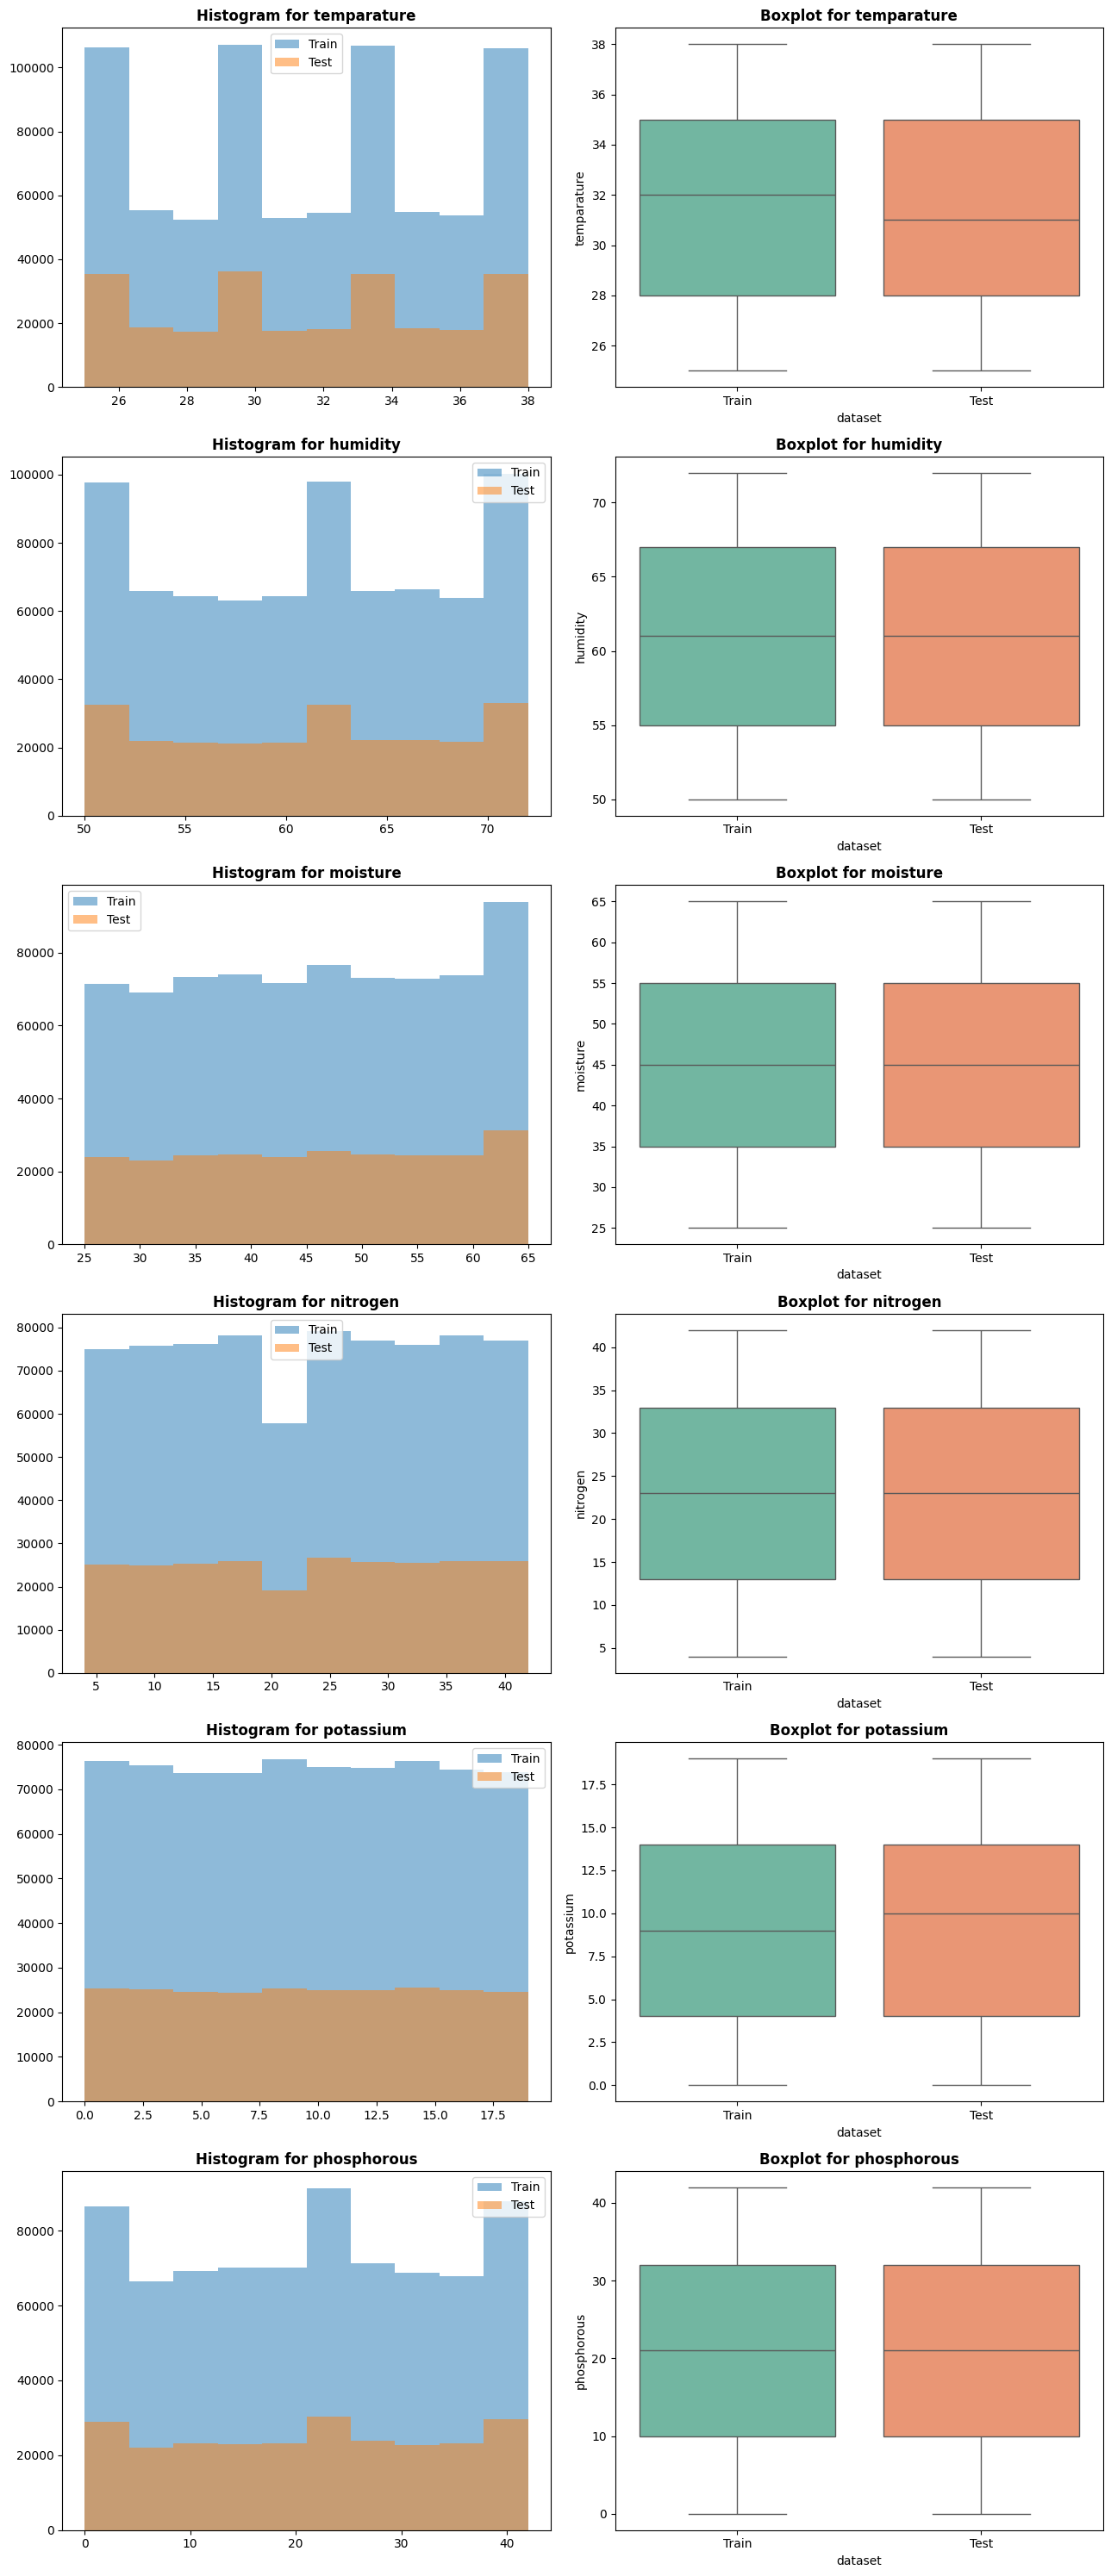

In [10]:
num_col = train_df.drop(columns=['id']).select_dtypes(include=['int', 'float64']).columns.tolist()

# Setup subplots
fig, axes = plt.subplots(len(num_col), 2, figsize=(13, 5 * len(num_col)))

# Plot histogram for train_df and test_df
for i, var in enumerate(num_col):
    axes[i, 0].hist(train_df[var], alpha=0.5, label='Train')
    axes[i, 0].hist(test_df[var], alpha=0.5, label='Test')
    axes[i, 0].set_title(f'Histogram for {var}', weight='bold')
    axes[i, 0].legend()

    # Prepare data for boxplot
    combined = pd.concat([train_df[var].to_frame().assign(dataset='Train'),
                          test_df[var].to_frame().assign(dataset='Test')])

    # Plot boxplot
    sns.boxplot(data=combined, x='dataset', y=var, ax=axes[i, 1], palette='Set2')
    axes[i, 1].set_title(f'Boxplot for {var}', weight='bold')

plt.tight_layout()
plt.show()

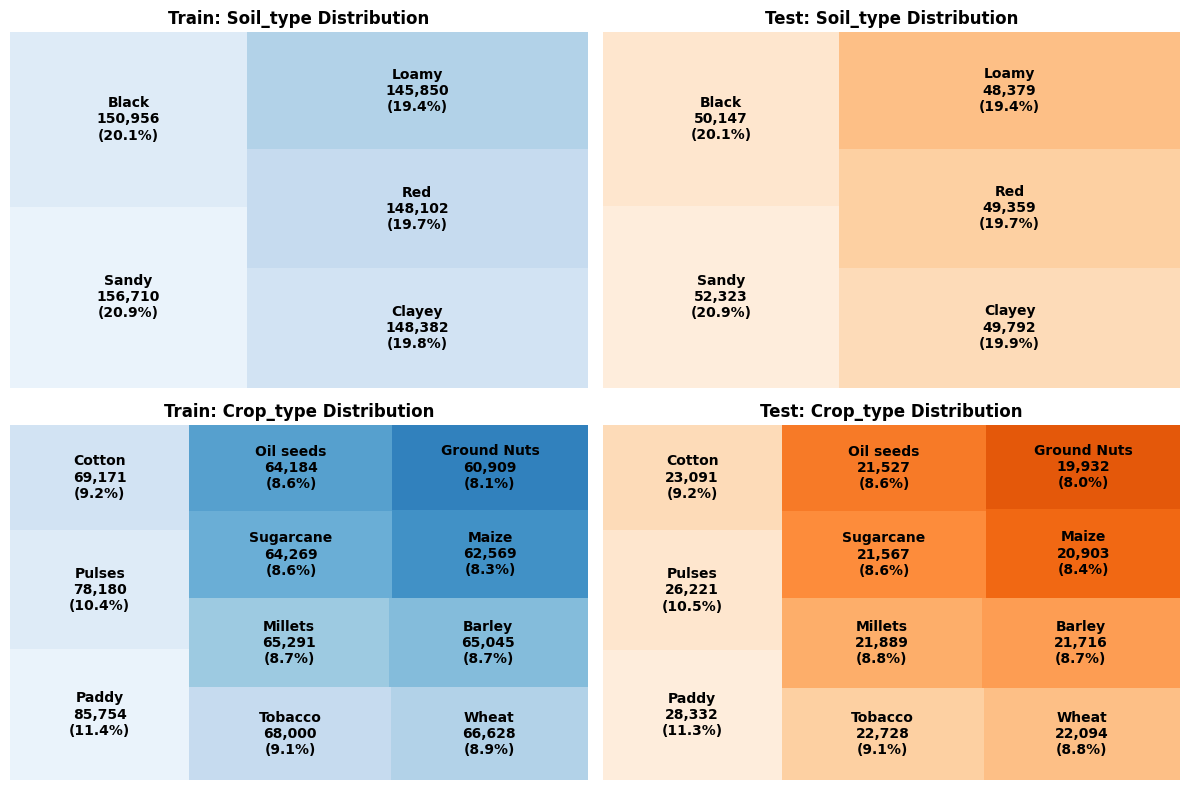

In [11]:
cat_col = train_df.drop(columns=['fertilizer_name']).select_dtypes(include=['object']).columns.tolist()

n_rows = len(cat_col)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows), squeeze=False)

# Set Color palette
train_colors = sns.color_palette("Blues", n_colors=15)
test_colors = sns.color_palette("Oranges", n_colors=15)

# Iterate over categorical variables
for i, var in enumerate(cat_col):
    # Calculate value counts for train and test
    train_counts = train_df[var].value_counts()
    test_counts = test_df[var].value_counts()

    # Get labels and sizes for treemaps
    train_labels = [f"{cat}\n{count:,}\n({count/len(train_df)*100:.1f}%)"
                    for cat, count in train_counts.items()]
    test_labels = [f"{cat}\n{count:,}\n({count/len(test_df)*100:.1f}%)"
                   for cat, count in test_counts.items()]
    train_sizes = train_counts.values
    test_sizes = test_counts.values

    # Plot treemap for train data
    axes[i, 0].set_title(f"Train: {var.capitalize()} Distribution", weight='bold')
    squarify.plot(sizes=train_sizes, label=train_labels, color=train_colors[:len(train_sizes)], ax=axes[i, 0],
        text_kwargs={'fontsize': 10, 'weight': 'bold'})
    axes[i, 0].axis('off')

    # Plot treemap for test data
    axes[i, 1].set_title(f"Test: {var.capitalize()} Distribution", weight='bold')
    squarify.plot(sizes=test_sizes, label=test_labels, color=test_colors[:len(test_sizes)], ax=axes[i, 1],
        text_kwargs={'fontsize': 10, 'weight': 'bold'})
    axes[i, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

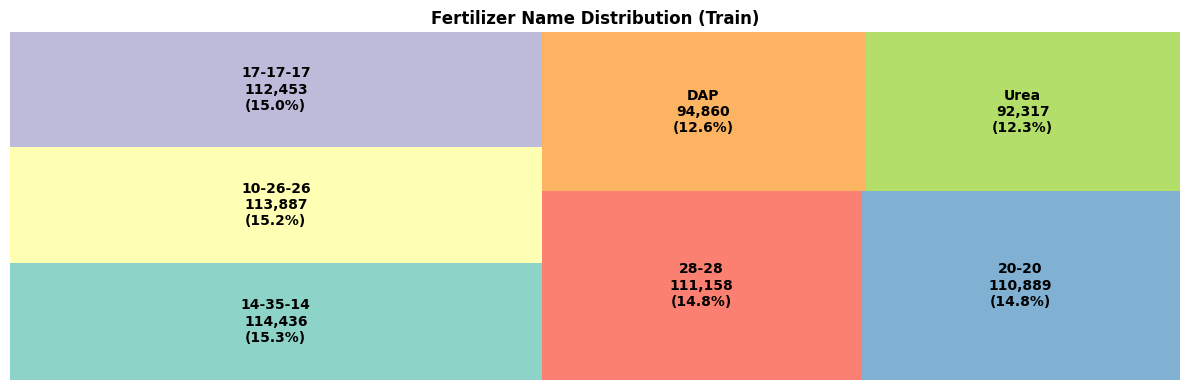

In [12]:
# Set figure size
plt.figure(figsize=(12, 4))

# Color palette
colors = sns.color_palette("Set3", n_colors=10)

# Calculate value counts for fertilizer_name
train_counts = train_df['fertilizer_name'].value_counts()

# Get labels and sizes for treemap
labels = [f"{cat}\n{count:,}\n({count/len(train_df)*100:.1f}%)"
          for cat, count in train_counts.items()]
sizes = train_counts.values

# Plot treemap
squarify.plot(sizes=sizes, label=labels,color=colors,
    text_kwargs={'fontsize': 10, 'weight': 'bold'})
plt.title("Fertilizer Name Distribution (Train)", weight='bold')
plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

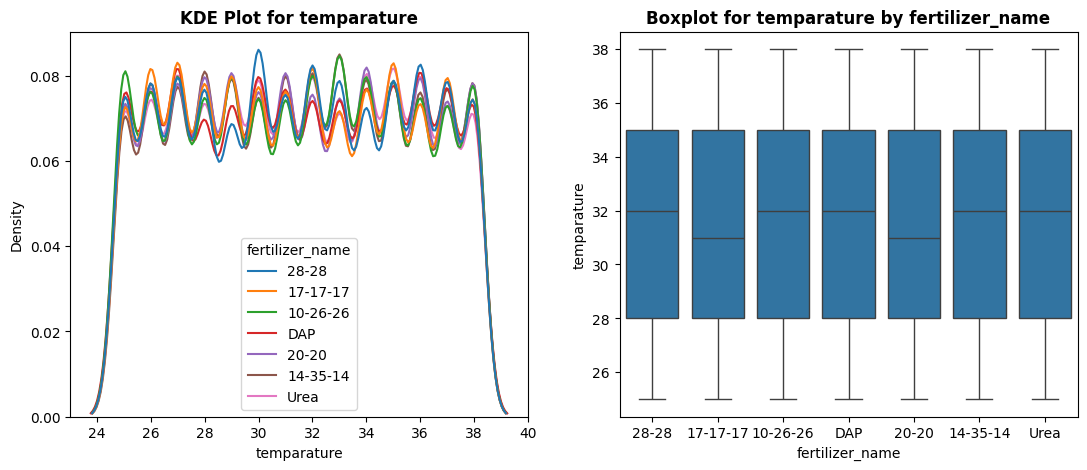

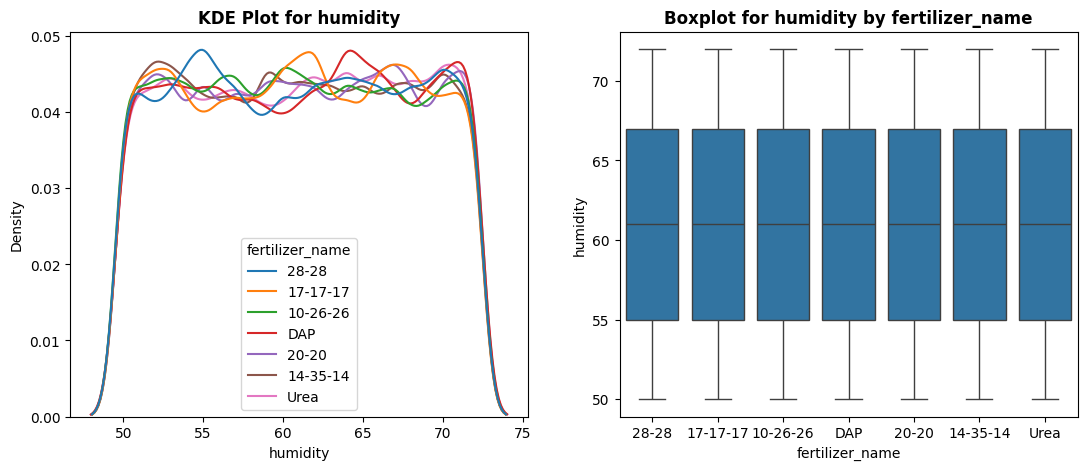

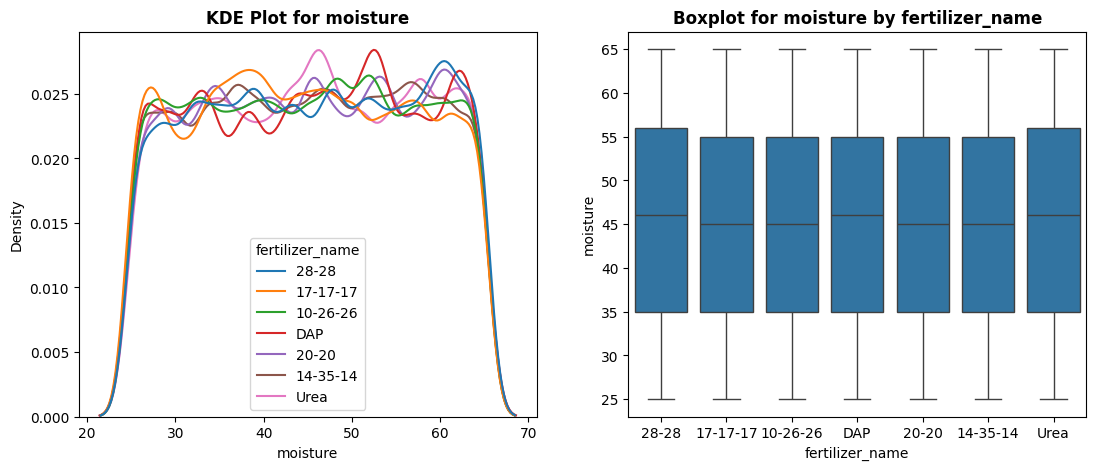

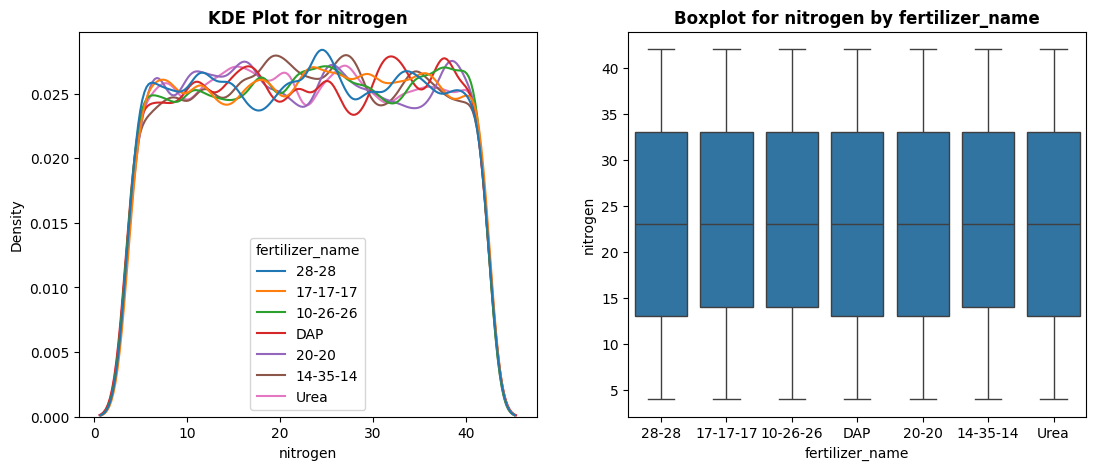

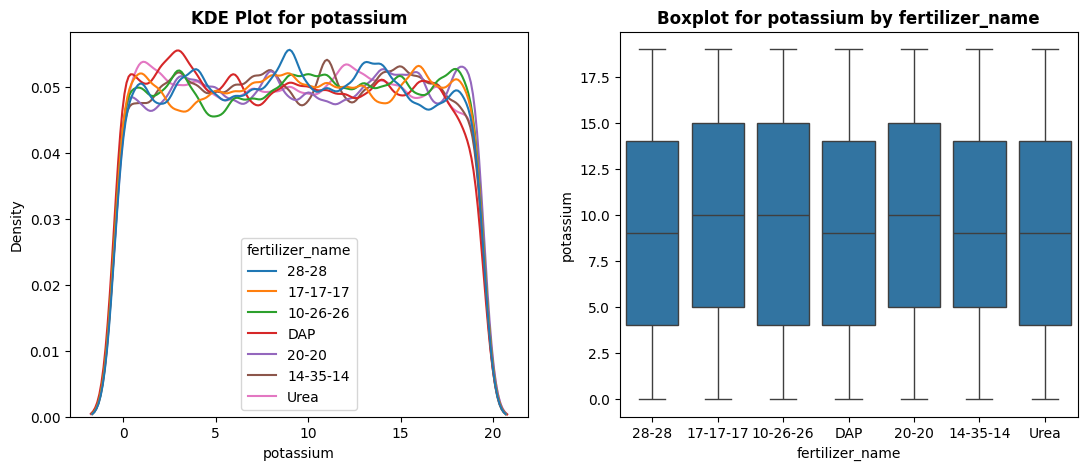

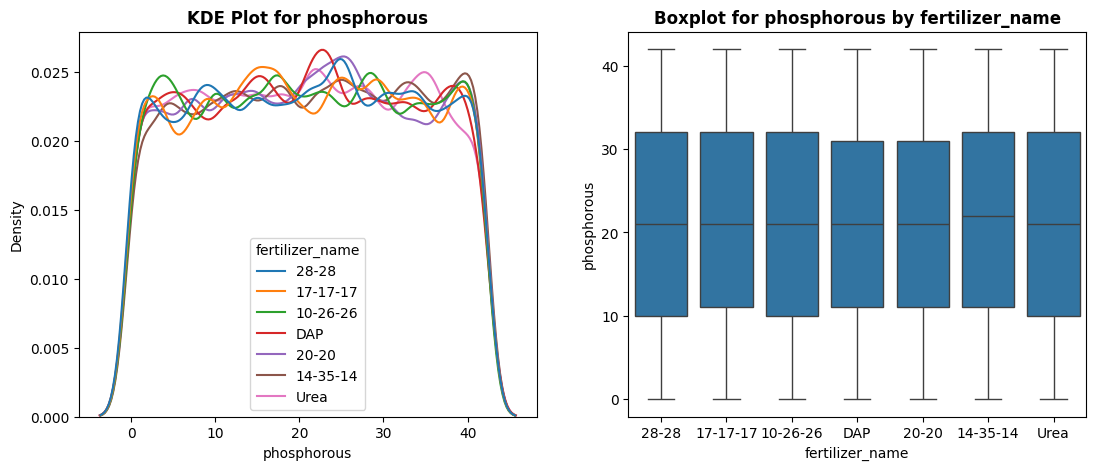

In [13]:
def kde_boxplot(col_name):
    # Setup subplots
    fig, axes = plt.subplots(1, 2, figsize=(13, 5 * 1))
    # Create KDE plot
    sns.kdeplot(data=train_df, x=col_name, hue='fertilizer_name', common_norm=False, ax=axes[0])
    axes[0].set_title(f'KDE Plot for {col_name}', weight='bold')
    # Create boxplot
    sns.boxplot(data=train_df, x='fertilizer_name', y=col_name)
    axes[1].set_title(f'Boxplot for {col_name} by fertilizer_name', weight='bold')
    plt.show()

kde_boxplot('temparature')
kde_boxplot('humidity')
kde_boxplot('moisture')
kde_boxplot('nitrogen')
kde_boxplot('potassium')
kde_boxplot('phosphorous')

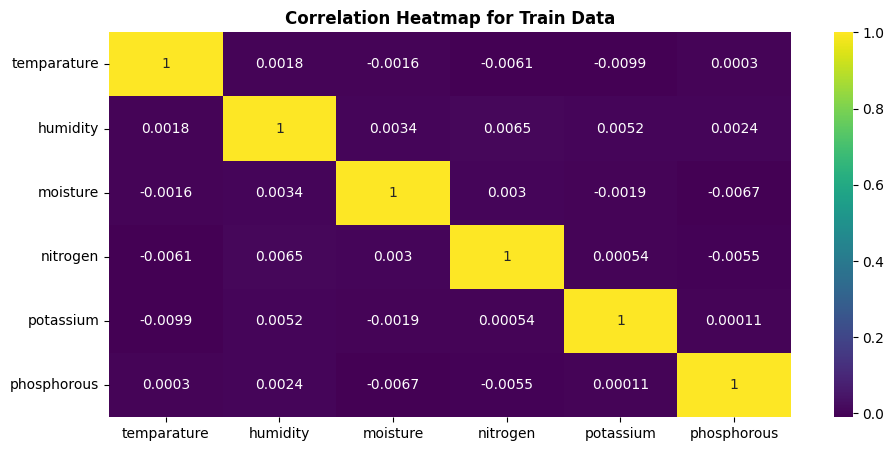

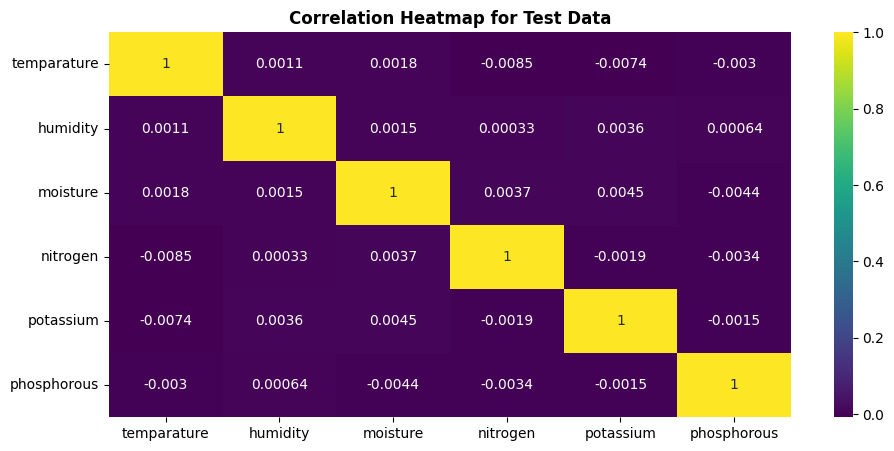

In [14]:
# Heatmap for train_df
plt.figure(figsize=(11, 5))
sns.heatmap(train_df.drop(columns=['id']).corr(method='pearson', numeric_only=True), annot=True, cmap='viridis')
plt.title('Correlation Heatmap for Train Data', fontsize=12, weight='bold')
plt.show();

# Heatmap for test_df
plt.figure(figsize=(11, 5))
sns.heatmap(test_df.drop(columns=['id']).corr(method='pearson', numeric_only=True), annot=True, cmap='viridis')
plt.title('Correlation Heatmap for Test Data', fontsize=12, weight='bold')
plt.show();

In [15]:
def create_features(df):
    # Categorical combos
    df['soil_crop_combo'] = df['soil_type'] +  "_" + df['crop_type']
    df['npk_sum'] = df['nitrogen'] + df['potassium'] + df['phosphorous']

    # Climate difference
    df['temp_moisture_diff'] = df['temparature'] - df['moisture']
    df['humidity_temp_diff'] = df['humidity'] - df['temparature']
    df['humidity_moisture_diff'] = df['humidity'] - df['moisture']

    # Climate ratio
    df['humidity_moisture_ratio'] = df['humidity'] / df['moisture']
    df['temp_humidity_ratio'] = df['temparature'] / df['humidity']
    df['temp_moisture_ratio'] = df['temparature'] / df['moisture']

    # Climate normalized ratios
    df['climate_sum'] = df['temparature'] + df['humidity'] + df['moisture']
    df['temp_pct'] = df['temparature'] / df['climate_sum']
    df['humidity_pct'] = df['humidity'] / df['climate_sum']
    df['moisture_pct'] = df['moisture'] / df['climate_sum']

    # Interaction features
    df['temp_humidity_moisture'] = df['temparature'] * df['humidity'] * df['moisture']
    df['nitrogen_phosphorous_potassium'] = df['nitrogen'] * df['phosphorous'] * df['potassium']

    # NPK ratios
    df['n_p_ratio'] = df['nitrogen'] / np.where(df['phosphorous'] == 0, 1, df['phosphorous'])
    df['n_k_ratio'] = df['nitrogen'] / np.where(df['potassium'] == 0, 1, df['potassium'])
    df['p_k_ratio'] = df['phosphorous'] / np.where(df['potassium'] == 0, 1, df['potassium'])

    # Nutrient balance index
    df['npk_balance'] = df['npk_sum'] / 3 - np.std([df['nitrogen'], df['phosphorous'], df['potassium']], axis=0)
    # Heat-drought stress signal
    df['hot_dry_conditions'] = df['temp_pct'] * (1 - df['humidity_pct'])
    # Balanced climate score
    df['ideal_growing_conditions'] = 1 / (1 + abs(df['temp_pct'] - 0.33) + abs(df['humidity_pct'] - 0.33) + abs(df['moisture_pct'] - 0.33))

    return df


def create_interaction_features(df):
    # Create climate interaction features
    climate_features = ['temparature', 'humidity', 'moisture']
    for i, col1 in enumerate(climate_features):
        for col2 in climate_features[i+1:]:
            df[f"{col1}_x_{col2}"] = df[col1] * df[col2]

    # Create NPK interaction featuers
    npk_features = ['nitrogen',	'potassium', 'phosphorous']
    for i, col1 in enumerate(npk_features):
        for col2 in npk_features[i+1:]:
            df[f"{col1}_x_{col2}"] = df[col1] * df[col2]

    # Create selective climate & npk interaction features
    df['nitrogen_x_temp'] = df['nitrogen'] * df['temparature']
    df['phosphorous_x_moisture'] = df['phosphorous'] * df['moisture']
    df['npk_sum_x_temp'] = df['npk_sum'] * df['temparature']
    df['potassium_x_humidity'] = df['potassium'] * df['humidity']

    return df

# Apply create_features
train_df = create_features(train_df)
test_df = create_features(test_df)

# Apply create_interaction_features
train_df = create_interaction_features(train_df)
test_df = create_interaction_features(test_df)
train_df.head(1)

,id,temparature,humidity,moisture,soil_type,crop_type,nitrogen,potassium,phosphorous,fertilizer_name,soil_crop_combo,npk_sum,temp_moisture_diff,humidity_temp_diff,humidity_moisture_diff,humidity_moisture_ratio,temp_humidity_ratio,temp_moisture_ratio,climate_sum,temp_pct,humidity_pct,moisture_pct,temp_humidity_moisture,nitrogen_phosphorous_potassium,n_p_ratio,n_k_ratio,p_k_ratio,npk_balance,hot_dry_conditions,ideal_growing_conditions,temparature_x_humidity,temparature_x_moisture,humidity_x_moisture,nitrogen_x_potassium,nitrogen_x_phosphorous,potassium_x_phosphorous,nitrogen_x_temp,phosphorous_x_moisture,npk_sum_x_temp,potassium_x_humidity
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,Clayey_Sugarcane,45,1,33,34,1.944444,0.528571,1.027778,143,0.258741,0.48951,0.251748,93240,720,7.2,9.0,1.25,0.145147,0.132085,0.76393,2590,1332,2520,144,180,20,1332,180,1665,280


In [16]:
def create_fertilizer_prob_features(train_df, valid_df, test_df, group_col, target_col):
    fertilizer_ohe = pd.get_dummies(train_df[target_col], prefix='prob_', dtype=float)
    temp_df = pd.concat([train_df[group_col].reset_index(drop=True), fertilizer_ohe], axis=1)
    group_prob = temp_df.groupby(group_col).mean().reset_index()

    train_df = train_df.merge(group_prob, on=group_col, how='left')
    valid_df = valid_df.merge(group_prob, on=group_col, how='left')
    test_df = test_df.merge(group_prob, on=group_col, how='left')
    return train_df, valid_df, test_df

In [17]:
for col in train_df.select_dtypes('object').columns:
    train_df[col] = train_df[col].astype('category')

# Changing the datatype for categorical variables from object to category in test_df
for col in test_df.select_dtypes('object').columns:
    test_df[col] = test_df[col].astype('category')

In [23]:
# Features & Target
X = train_df.drop(columns=['id'])
X_test = test_df.drop(columns=['id'])

y = train_df['fertilizer_name']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# MAP@3 function
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        if a in p[:k]:
            return 1.0 / (p[:k].index(a) + 1)
        return 0.0

    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


# LightGBM hyper-parameter
lgbm_params = {
    'n_estimators': 12000,
    'learning_rate': 0.01,
    'subsample': 0.75,
    'colsample_bytree': 0.75,
    'reg_lambda': 0.3,
    'reg_alpha': 0.3,
    'num_leaves': 64,
    'max_depth': 10,
    'min_child_samples': 30,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 7,
    'device': 'gpu',
    'random_state': 42,
    'verbosity': -1,
    'early_stopping_rounds':50,
}

# XGBoost hyper-parameter
xgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'max_depth': 10,
    'subsample': 0.75,
    'colsample_bytree': 0.75,
    'reg_lambda': 0.3,
    'reg_alpha': 0.3,
    'objective': 'multi:softprob',
    'num_class': 7,
    'tree_method': 'gpu_hist',
    'enable_categorical':True,
    'random_state': 42,
    'early_stopping_rounds':50,
}

In [24]:
def train_model(X, y, X_test, model_name, params):
    print(f"\n##### Training {model_name} Model #####")

    oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
    test_preds = np.zeros((X_test.shape[0], len(np.unique(y))))
    map3_scores = []
    feature_importances = pd.DataFrame()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f"\n### Fold {fold+1} ###")

        X_train, y_train = X.iloc[train_idx], y_encoded[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y_encoded[valid_idx]
        X_test_fold = X_test.copy()

        # Add fertilizer probabilities features
        X_train, X_valid, X_test_fold = create_fertilizer_prob_features(
            train_df=X_train,
            valid_df=X_valid,
            test_df=X_test_fold,
            group_col='soil_type',
            target_col='fertilizer_name'
        )

        # Drop Target variable
        X_train.drop(columns=['fertilizer_name'], inplace=True)
        X_valid.drop(columns=['fertilizer_name'], inplace=True)

        # Train model
        if model_name == "LightGBM":
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train,
                      eval_set=[(X_valid, y_valid)],
                      callbacks=[early_stopping(stopping_rounds=100, verbose=False)])

            # Feature importance
            fold_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': model.feature_importances_,
                'fold': fold + 1
            })
            feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

        elif model_name == "XGBoost":
            model = XGBClassifier(**params)
            model.fit(X_train, y_train,
                      eval_set=[(X_valid, y_valid)],
                      verbose=100)

            # Feature importance
            importance_dict = model.get_booster().get_score(importance_type='gain')
            fold_importance = pd.DataFrame({
            "feature": X_train.columns,
            "importance": [importance_dict.get(feat, 0) for feat in X_train.columns],
            "fold": fold + 1})
            feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

        else:
            raise ValueError("Invalid model_name. Choose 'LightGBM' or 'XGBoost'.")

        # Validation & test predictions
        valid_preds = model.predict_proba(X_valid)
        test_preds += model.predict_proba(X_test_fold) / skf.n_splits

        # OOF predictions
        oof_preds[valid_idx] = valid_preds

        # MAP@3 Score
        top3_preds = np.argsort(valid_preds, axis=1)[:, -3:][:, ::-1]
        top3_labels = [[le.inverse_transform([i])[0] for i in row] for row in top3_preds]
        true_labels = le.inverse_transform(y_valid)
        map3 = mapk(true_labels, top3_labels, k=3)
        print(f"Fold {fold + 1} MAP@3: {map3:.5f}")
        map3_scores.append(map3)

    # Average MAP@3 score
    print(f"\nAverage MAP@3: {np.mean(map3_scores):.5f}")

    # Final OOF MAP@3 Score
    top3_preds_oof = np.argsort(oof_preds, axis=1)[:, -3:][:, ::-1]
    top3_labels_oof = [[le.inverse_transform([i])[0] for i in row] for row in top3_preds_oof]
    true_labels_oof = le.inverse_transform(y_encoded)
    oof_map3 = mapk(true_labels_oof, top3_labels_oof, k=3)
    print(f"OOF MAP@3 Score: {oof_map3:.5f}\n")

    return oof_preds, test_preds, feature_importances, map3_scores

In [25]:
%%time
# Run XGBoost
xgb_oof, xgb_test, xgb_feature_importances, xgb_scores = train_model(X, y, X_test, model_name='XGBoost', params=xgb_params)


##### Training XGBoost Model #####

### Fold 1 ###
[0]	validation_0-mlogloss:1.94580
[100]	validation_0-mlogloss:1.93781
[200]	validation_0-mlogloss:1.93392
[300]	validation_0-mlogloss:1.93148
[400]	validation_0-mlogloss:1.92981
[500]	validation_0-mlogloss:1.92848
[600]	validation_0-mlogloss:1.92746
[700]	validation_0-mlogloss:1.92667
[800]	validation_0-mlogloss:1.92615
[900]	validation_0-mlogloss:1.92577
[1000]	validation_0-mlogloss:1.92556
[1100]	validation_0-mlogloss:1.92539
[1200]	validation_0-mlogloss:1.92534
[1271]	validation_0-mlogloss:1.92533
Fold 1 MAP@3: 0.32163

### Fold 2 ###
[0]	validation_0-mlogloss:1.94579
[100]	validation_0-mlogloss:1.93780
[200]	validation_0-mlogloss:1.93391
[300]	validation_0-mlogloss:1.93159
[400]	validation_0-mlogloss:1.92996
[500]	validation_0-mlogloss:1.92877
[600]	validation_0-mlogloss:1.92779
[700]	validation_0-mlogloss:1.92711
[800]	validation_0-mlogloss:1.92660
[900]	validation_0-mlogloss:1.92624
[1000]	validation_0-mlogloss:1.92599
[1100]	va

In [26]:
%%time
# Run LightGBM
lgbm_oof, lgbm_test, lgbm_feature_importances, lgbm_scores = train_model(X, y, X_test, model_name='LightGBM', params=lgbm_params)


##### Training LightGBM Model #####

### Fold 1 ###
Fold 1 MAP@3: 0.32390

### Fold 2 ###
Fold 2 MAP@3: 0.32228

### Fold 3 ###
Fold 3 MAP@3: 0.32219

### Fold 4 ###
Fold 4 MAP@3: 0.32176

### Fold 5 ###
Fold 5 MAP@3: 0.32154

Average MAP@3: 0.32233
OOF MAP@3 Score: 0.32233

CPU times: user 3h 11min 43s, sys: 47.3 s, total: 3h 12min 30s
Wall time: 54min 41s


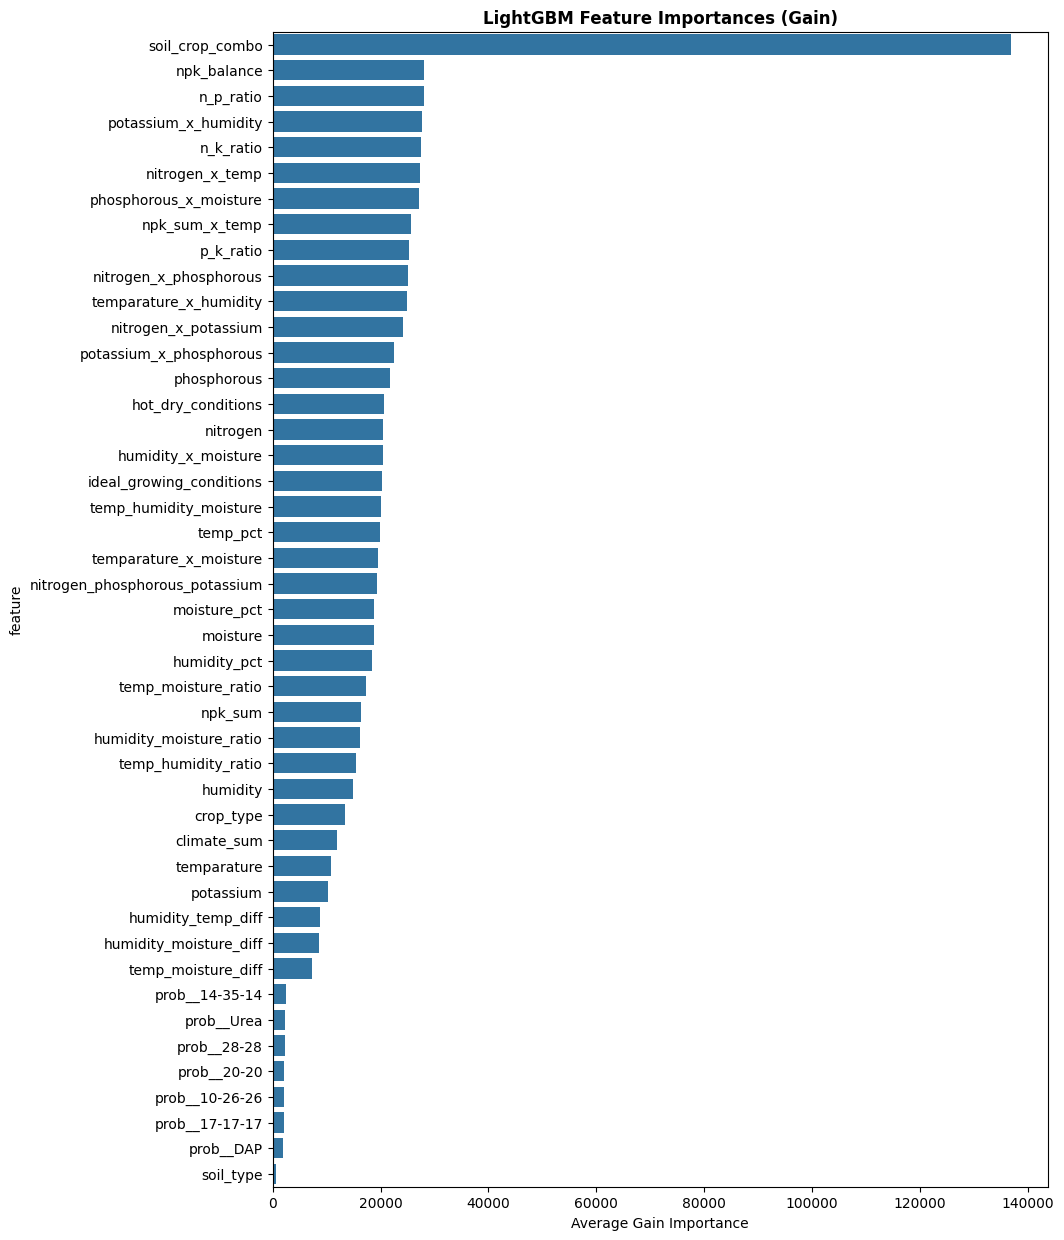

In [27]:
# Average importance from LightGBM
lgb_avg_importance = lgbm_feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

# Plot LightGBM feature importance
plt.figure(figsize=(10, 15))
sns.barplot(data=lgb_avg_importance, x='importance', y='feature')
plt.title("LightGBM Feature Importances (Gain)", weight="bold")
plt.xlabel("Average Gain Importance");

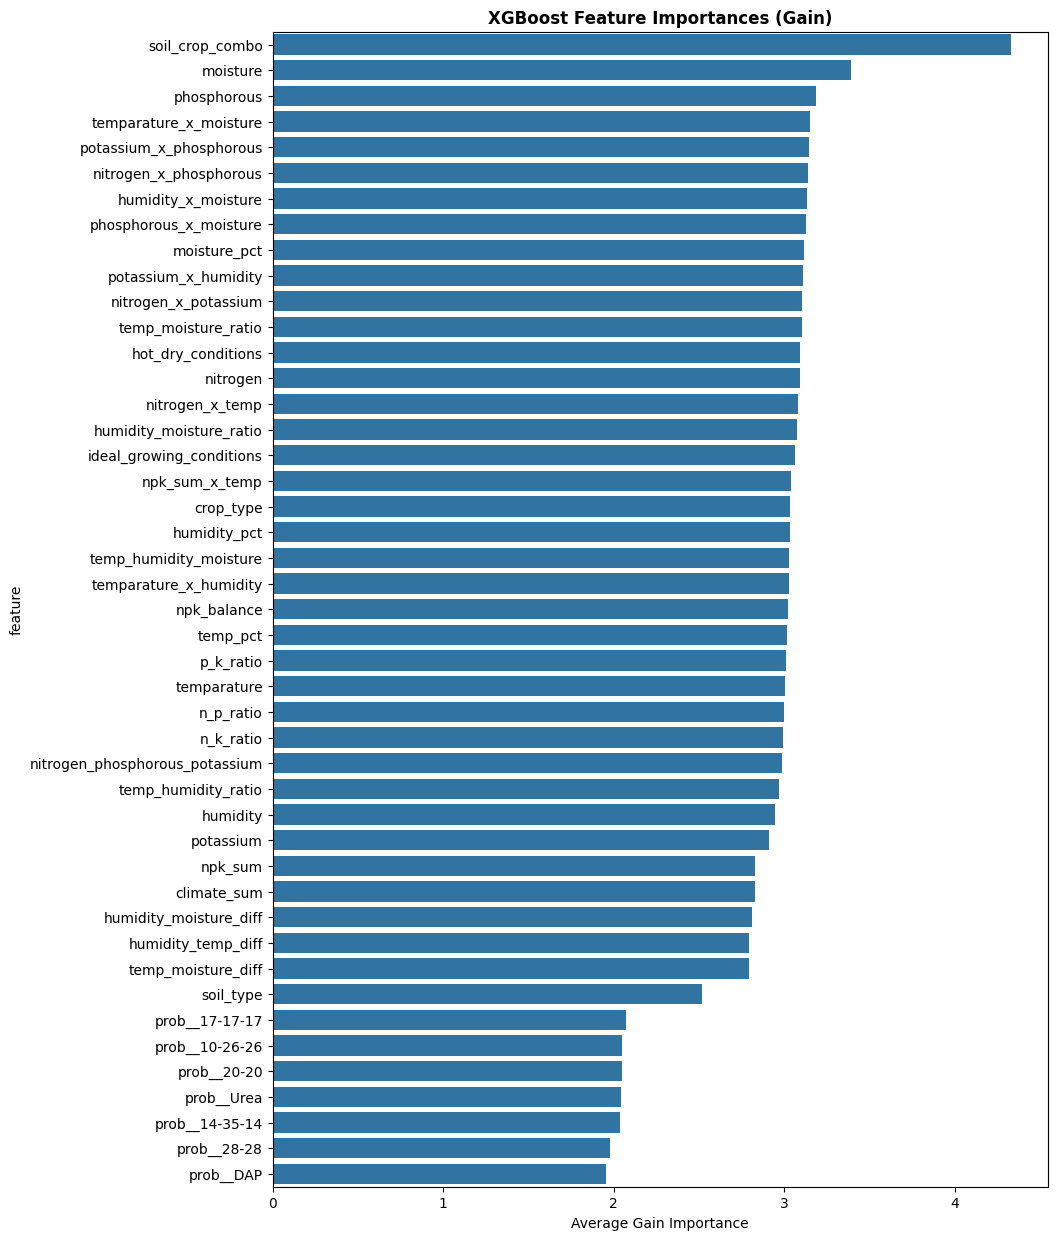

In [28]:
# Average importance from XGBoost
xgb_avg_importance = xgb_feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

# Plot XGBoost feature importance
plt.figure(figsize=(10, 15))
sns.barplot(data=xgb_avg_importance, x='importance', y='feature')
plt.title("XGBoost Feature Importances (Gain)", weight="bold")
plt.xlabel("Average Gain Importance");

In [29]:
# Get top 3 predicted class indices from probabilities
top3_preds_test = np.argsort(lgbm_test, axis=1)[:, -3:][:, ::-1]

# Convert class indices to fertilizer names using the label encoder
top3_labels_test = [
    " ".join([le.inverse_transform([i])[0] for i in row]) for row in top3_preds_test
]

# Prepare submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'Fertilizer Name': top3_labels_test
})

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Final submission file created")

submission.head()

Final submission file created


,id,Fertilizer Name
0,750000,28-28 17-17-17 DAP
1,750001,17-17-17 20-20 10-26-26
2,750002,20-20 14-35-14 28-28
3,750003,14-35-14 17-17-17 Urea
4,750004,20-20 10-26-26 14-35-14


In [ ]:
X.info

In [ ]:
X = train_df.drop(columns=['id'])
X_test = test_df.drop(columns=['id'])

y = train_df['fertilizer_name']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
from pycaret.regression import * # classification 대신 regression 임포트
import pandas as pd

# PyCaret 회귀 setup 함수 호출
# target 컬럼은 연속형 회귀 문제이므로 'target'으로 지정합니다.
pyc_reg = setup(
    data=df_train,
    target='target',  # 예측하고자 하는 target 컬럼을 명시합니다. (연속형 회귀)
    categorical_features=categorical_column,
    numeric_features=continuous_column,
    train_size=0.8,
    normalize=True,
    normalize_method='minmax',
    session_id=42,
)

# 여러 회귀 모델을 비교하고 가장 좋은 모델 선택
# sort 기준을 'R2', 'MAE', 'MSE', 'RMSE' 등으로 변경할 수 있습니다.
# include 파라미터에 원하는 회귀 모델의 ID를 지정할 수 있습니다.
# ('lr': Linear Regression, 'lasso': Lasso Regression, 'ridge': Ridge Regression,
# 'en': Elastic Net, 'lar': Least Angle Regression, 'llar': Lasso Least Angle Regression,
# 'omp': Orthogonal Matching Pursuit, 'br': Bayesian Ridge, 'ard': Automatic Relevance Determination,
# 'par': Passive Aggressive Regressor, 'huber': Huber Regressor, 'knn': K Neighbors Regressor,
# 'dt': Decision Tree Regressor, 'rf': Random Forest Regressor, 'et': Extra Trees Regressor,
# 'ada': AdaBoost Regressor, 'gbr': Gradient Boosting Regressor, 'mlp': MLP Regressor,
# 'lightgbm': Light Gradient Boosting Machine, 'xgboost': XGBoost Regressor,
# 'catboost': CatBoost Regressor, 'dummy': Dummy Regressor)
models = compare_models(
    fold=5,
    sort='RMSE',  # 회귀 모델의 경우 'R2', 'MAE', 'MSE', 'RMSE' 등을 주로 사용
    n_select=6,
    include=['lr', 'dt', 'rf', 'gbr', 'xgboost', 'lightgbm', 'ada'] # 회귀 모델 ID
)